['Telco-Customer-Churn.csv', 'Input3', 'Input2', '.ipynb_checkpoints', 'input7']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0xb2bc70710>,
      dtype=object)

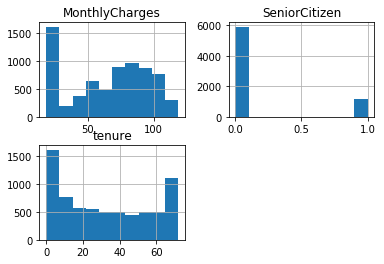

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
import shutil
import tensorflow as tf
print(os.listdir("Input"))
#Importing the dataset
df=pd.read_csv('Telco-Customer-Churn.csv')
df.hist()

In [4]:
###Some pre-processing!
#TotalCharges has empty rows: Replace them with nan
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
#Okay now lets see how many nan values we have
df['TotalCharges'].isnull().sum()
# Out of 7043 there are 11 customers with no total charge reported
##lets see if  monthly payment and membership times are complete?
[df['tenure'].isnull().sum(),df['MonthlyCharges'].isnull().sum()]
df_col_names = df.columns.tolist()[1:20]
## either drop nan values or impute them
#df=df.dropna() #drop nan values
#or we can imput them in two ways:
#1) use fillna from pandas:  
#df=df.fillna(method="backfill")
#1)or use customers infor to fill the missing values: easier way can be TotalCharge=MonthlyCharges*tenure(membership_length)
df['TotalCharges'].fillna(value=df['tenure'] * df['MonthlyCharges'], inplace=True)
#Unifing features: Only SeniorCitizen is boolean 0 or 1, lets make it yes and no
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes',0: 'No'}) 
df.info()
# three numerical feature:Num_col and 16 categorical ones
numeric_feature  = ['tenure', 'MonthlyCharges', 'TotalCharges']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null object
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(1), o

In [6]:
#target variable-Churn- is an object with yes and no, convert it to 1 and 0! 
df['Churn']=df['Churn'].astype('category').cat.codes
customerID=df['customerID']
numeric_feature  = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_feature_cols = [tf.feature_column.numeric_column(c) for c in numeric_feature]
categorical_feature_name  = [i for i in df_col_names if i not in numeric_feature]
dim_cat=[len(df[i].unique()) for i in categorical_feature_name]

In [45]:
#Set feature matrix and target variable as X and Y
X = df.drop(['customerID','Churn'], axis=1) #19 features and 7043 customers
Y = df['Churn']
# split data into train and test datasets:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)


In [10]:
#Create input functions for train and test
batch_size = 100
train_input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=batch_size,num_epochs=1000, shuffle=True)
test_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=batch_size,num_epochs=1,shuffle=False)
n_classes = 2 # binary classifier for churn yes or no


In [58]:
#######  Linear classifier
#Create feature columns  for numerical and categorical features
shutil.rmtree("Input/Input1")
categorical_features = [tf.feature_column.categorical_column_with_hash_bucket(c, hash_bucket_size=size) 
            for c, size in zip(categorical_feature_name, dim_cat)]
all_feature_columns = numeric_feature_cols + categorical_features
#train the classifier:
classifier_linear= tf.estimator.LinearClassifier(feature_columns=all_feature_columns, n_classes=n_classes,model_dir="Input/Input1")
tf.logging.set_verbosity(tf.logging.ERROR)
classifier_linear.train(input_fn=train_input_func, steps=10000) 

In [62]:
#Evaluate classifier and predict y_test based on the classifier:
y_pred = classifier_linear.predict(test_input_func)
y_preds= [i['class_ids'][0] for i in y_pred]
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds, target_names=['0','1']))
classifier_linear.evaluate(test_input_func)

[[1218  109]
 [ 242  192]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1327
           1       0.64      0.44      0.52       434

    accuracy                           0.80      1761
   macro avg       0.74      0.68      0.70      1761
weighted avg       0.79      0.80      0.79      1761



{'accuracy': 0.8006814,
 'accuracy_baseline': 0.7535491,
 'auc': 0.744876,
 'auc_precision_recall': 0.5842977,
 'average_loss': 0.98430985,
 'label/mean': 0.24645089,
 'loss': 96.29831,
 'precision': 0.63787377,
 'prediction/mean': 0.19007458,
 'recall': 0.4423963,
 'global_step': 10000}

In [79]:
#####DNNclassifier
#Create Dense feature columns using embedding_column 
shutil.rmtree("Input/Input2")
vocab_categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(key=c,vocabulary_list=X[c].unique(),default_value=0)
                      for c, size in zip(categorical_feature_name, dim_cat)]
embed_categorical_features = [tf.feature_column.embedding_column(c,dimension=size)
                      for c, size in zip(vocab_categorical_features, dim_cat)]
all_embed_feature_columns = numeric_feature_cols + embed_categorical_features
#DNNclassifier:
dnnclassifier= tf.estimator.DNNClassifier(feature_columns=all_embed_feature_columns, hidden_units=[8,6],n_classes=n_classes,model_dir="Input/Input2")
##train the classifier:
tf.logging.set_verbosity(tf.logging.ERROR)
dnnclassifier.train(input_fn=train_input_func, steps=10000) 

In [80]:
#Evaluate classifier and predict y_test based on the classifier:
dnnclassifier.evaluate(test_input_func)
y_pred = dnnclassifier.predict(pred_input_func)
y_preds= [i['class_ids'][0] for i in y_pred]
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds, target_names=['0','1']))
dnnclassifier.evaluate(test_input_func)

[[984 343]
 [ 80 354]]
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1327
           1       0.51      0.82      0.63       434

    accuracy                           0.76      1761
   macro avg       0.72      0.78      0.72      1761
weighted avg       0.82      0.76      0.77      1761



{'accuracy': 0.75979555,
 'accuracy_baseline': 0.7535491,
 'auc': 0.8573633,
 'auc_precision_recall': 0.6659124,
 'average_loss': 0.46565956,
 'label/mean': 0.24645089,
 'loss': 45.557026,
 'precision': 0.50789094,
 'prediction/mean': 0.3930745,
 'recall': 0.8156682,
 'global_step': 10000}

In [65]:
########### Model 1 - adding regularisation to LinearClassifier:
shutil.rmtree("Input/Input3")
classifier_linear_m1 = tf.estimator.LinearClassifier(feature_columns=all_feature_columns,
model_dir="Input/Input3",optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,l1_regularization_strength=0.9,l2_regularization_strength=5))
tf.logging.set_verbosity(tf.logging.ERROR)
classifier_linear_m1.train(input_fn=train_input_func, steps=10000)

In [66]:
classifier_linear_m1.evaluate(input_fn=test_input_func, steps=1)
y_pred_l = classifier_linear_m1.predict(input_fn=test_input_func) 
y_preds_l= [i['class_ids'][0] for i in y_pred_l]
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_preds_l))
print(classification_report(y_test, y_preds_l, target_names=['0','1']))
classifier_linear_m1.evaluate(input_fn=test_input_func, steps=1)

[[1142  185]
 [ 196  238]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1327
           1       0.56      0.55      0.56       434

    accuracy                           0.78      1761
   macro avg       0.71      0.70      0.71      1761
weighted avg       0.78      0.78      0.78      1761



{'accuracy': 0.83,
 'accuracy_baseline': 0.79,
 'auc': 0.78450876,
 'auc_precision_recall': 0.6114788,
 'average_loss': 0.5334668,
 'label/mean': 0.21,
 'loss': 53.34668,
 'precision': 0.5833333,
 'prediction/mean': 0.274057,
 'recall': 0.6666667,
 'global_step': 10000}

In [81]:
########### Model 1 - adding regularisation to DNNClassifier:
#all_feature_columns = numeric_feature_cols + categorical_features
shutil.rmtree("Input/Input4")
all_embed_feature_columns = numeric_feature_cols + embed_categorical_features
#DNNclassifier:
dnnclassifier= tf.estimator.DNNClassifier(feature_columns=all_embed_feature_columns, hidden_units=[8,6],model_dir="Input/Input4",optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,l1_regularization_strength=0.4,l2_regularization_strength=1))
tf.logging.set_verbosity(tf.logging.ERROR)
classifier_linear_m1.train(input_fn=train_input_func, steps=10000)

In [83]:
classifier_linear_m1.evaluate(input_fn=test_input_func, steps=1)
y_pred_l = classifier_linear_m1.predict(input_fn=test_input_func) 
y_preds_l= [i['class_ids'][0] for i in y_pred_l]
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_preds_l))
print(classification_report(y_test, y_preds_l, target_names=['0','1']))
classifier_linear_m1.evaluate(input_fn=test_input_func, steps=1)

[[1153  174]
 [ 186  248]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1327
           1       0.59      0.57      0.58       434

    accuracy                           0.80      1761
   macro avg       0.72      0.72      0.72      1761
weighted avg       0.79      0.80      0.79      1761



{'accuracy': 0.83,
 'accuracy_baseline': 0.79,
 'auc': 0.8318264,
 'auc_precision_recall': 0.67544824,
 'average_loss': 0.4205153,
 'label/mean': 0.21,
 'loss': 42.05153,
 'precision': 0.5769231,
 'prediction/mean': 0.29943252,
 'recall': 0.71428573,
 'global_step': 30000}

In [91]:
########### Model 2 - bucketting the tenure variable.
# Bucketized feature creation 
shutil.rmtree("Input/Input5")
df_col_names = df.columns.tolist()[1:20]
tenure = tf.feature_column.numeric_column('tenure')
tenure_buckets = tf.feature_column.bucketized_column(
    tenure, boundaries=[6,12,24])
# Cross terms feature creation between Security,Backup and protection which might affect custumers 
sec_back_protec = [tf.feature_column.crossed_column(
    ['OnlineSecurity', 'OnlineBackup','DeviceProtection'], hash_bucket_size=1000)]
tenure_buckets_sec_back_protec = [tf.feature_column.crossed_column(
    [tenure_buckets, 'OnlineSecurity', 'OnlineBackup','DeviceProtection'], hash_bucket_size=1000)]
base_columns = [tenure_buckets,]
numeric_feature  = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_feature_cols = [tf.feature_column.numeric_column(c) for c in numeric_feature]
categorical_feature_name  = [i for i in df_col_names if i not in numeric_feature]
dim_cat=[len(df[i].unique()) for i in categorical_feature_name]
categorical_features = [tf.feature_column.categorical_column_with_hash_bucket(c, hash_bucket_size=size) 
        for c, size in zip(categorical_feature_name, dim_cat)]
###LinearClassifier:
feature_columns_bucket=categorical_features+base_columns+sec_back_protec+tenure_buckets_sec_back_protec
classifier_linear_m2 = tf.estimator.LinearClassifier(feature_columns=feature_columns_bucket,model_dir="Input/Input5",optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,l1_regularization_strength=0.9,l2_regularization_strength=5))
tf.logging.set_verbosity(tf.logging.ERROR)
classifier_linear_m2.train(input_fn=train_input_func, steps=10000)

In [92]:
classifier_linear_m2.evaluate(input_fn=test_input_func, steps=1)
y_pred_l = classifier_linear_m2.predict(input_fn=test_input_func) 
y_preds_l= [i['class_ids'][0] for i in y_pred_l]
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_preds_l))
print(classification_report(y_test, y_preds_l, target_names=['0','1']))
classifier_linear_m2.evaluate(input_fn=test_input_func, steps=1)

[[1013  314]
 [ 112  322]]
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1327
           1       0.51      0.74      0.60       434

    accuracy                           0.76      1761
   macro avg       0.70      0.75      0.71      1761
weighted avg       0.80      0.76      0.77      1761



{'accuracy': 0.73,
 'accuracy_baseline': 0.79,
 'auc': 0.85262203,
 'auc_precision_recall': 0.68869144,
 'average_loss': 0.5168109,
 'label/mean': 0.21,
 'loss': 51.681087,
 'precision': 0.42857143,
 'prediction/mean': 0.43084568,
 'recall': 0.85714287,
 'global_step': 10000}

In [71]:
########## Model 4:Balancing dataset: LinearClassifier
#Resampled train dataset samples per class Counter({0: , 1})
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_train_resampled=pd.DataFrame(data=X_resampled,columns=df_col_names)
y_train_resampled=pd.Series(data=y_resampled,name='Churn')
keys = X_train.keys()
for s in keys: 
    tipe = X_train[s].dtype
    X_train_resampled[s]=X_train_resampled[s].astype(tipe)
 # Prepare train and test datasets:
#X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=1)
[(y_train_resampled == 0).sum(),(y_train_resampled == 1).sum()]

[3847, 3847]

In [93]:
######Balancing dataset: LinearClassifier
#Input functions and feature columns
shutil.rmtree("Input/Input7")
batch_size = 100
train_input_func = tf.estimator.inputs.pandas_input_fn(x=X_train_resampled, y=y_train_resampled, batch_size=batch_size,num_epochs=1000, shuffle=True)
test_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,y=y_test,batch_size=batch_size,num_epochs=1,shuffle=False)
n_classes = 2 # binary classifier for churn yes or no
###LinearClassifier with regularisation
classifier_linear_m4 = tf.estimator.LinearClassifier(feature_columns=all_feature_columns,model_dir="Input/input7",optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,l1_regularization_strength=0.2,l2_regularization_strength=1))
tf.logging.set_verbosity(tf.logging.ERROR)
classifier_linear_m4.train(input_fn=train_input_func, steps=10000)

In [94]:
classifier_linear_m4.evaluate(input_fn=test_input_func, steps=1)
y_pred_l = classifier_linear_m4.predict(input_fn=test_input_func) 
y_preds_l= [i['class_ids'][0] for i in y_pred_l]
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_preds_l))
print(classification_report(y_test, y_preds_l, target_names=['0','1']))
classifier_linear_m4.evaluate(input_fn=test_input_func, steps=1)

[[1177  150]
 [ 200  234]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1327
           1       0.61      0.54      0.57       434

    accuracy                           0.80      1761
   macro avg       0.73      0.71      0.72      1761
weighted avg       0.79      0.80      0.80      1761



{'accuracy': 0.83,
 'accuracy_baseline': 0.79,
 'auc': 0.81374323,
 'auc_precision_recall': 0.64844054,
 'average_loss': 0.43010226,
 'label/mean': 0.21,
 'loss': 43.010227,
 'precision': 0.59090906,
 'prediction/mean': 0.26860404,
 'recall': 0.61904764,
 'global_step': 10000}

In [86]:
########## Model 4:Balancing dataset: DNNClassifier
###DNNClassifier with regularisation
shutil.rmtree("Input/Input8")
dnnclassifier= tf.estimator.DNNClassifier(feature_columns=all_embed_feature_columns, hidden_units=[8,6],model_dir="Input/Input8",optimizer=tf.train.FtrlOptimizer(learning_rate=0.1,l1_regularization_strength=0.1,l2_regularization_strength=.5))
tf.logging.set_verbosity(tf.logging.ERROR)
dnnclassifier.train(input_fn=train_input_func, steps=10000)

In [87]:
dnnclassifier.evaluate(input_fn=test_input_func, steps=1)
y_pred_l = dnnclassifier.predict(input_fn=test_input_func) 
y_preds_l= [i['class_ids'][0] for i in y_pred_l]
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test, y_preds_l))
print(classification_report(y_test, y_preds_l, target_names=['0','1']))
dnnclassifier.evaluate(input_fn=test_input_func, steps=1)

[[1163  164]
 [ 186  248]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1327
           1       0.60      0.57      0.59       434

    accuracy                           0.80      1761
   macro avg       0.73      0.72      0.73      1761
weighted avg       0.80      0.80      0.80      1761



{'accuracy': 0.84,
 'accuracy_baseline': 0.79,
 'auc': 0.835443,
 'auc_precision_recall': 0.65404534,
 'average_loss': 0.420402,
 'label/mean': 0.21,
 'loss': 42.0402,
 'precision': 0.6086956,
 'prediction/mean': 0.32175225,
 'recall': 0.6666667,
 'global_step': 10000}